In [1]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
from torchvision.datasets import MNIST
import torch.nn as nn
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam #Adam for GD
import time


In [3]:
hidden_dim = 128
input_dim = 28
output_dim = 10 
num_layers = 1

In [4]:
class Vanilla_RNN(nn.Module):

    def __init__(self ,input_dim, hidden_dim, num_layers, output_dim):
        super(Vanilla_RNN,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim,hidden_dim,batch_first =True)

        self.Hidden_layer = nn.Linear(hidden_dim,output_dim)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        #x = x.permute(1, 0, 2)
        hiddenlayer=torch.zeros(1,x.size(0),hidden_dim)
        out, hn = self.rnn(x, hiddenlayer.detach())
        out = self.Hidden_layer(out[:, -1, :]) #hidden states of last time step
        pred=self.log_softmax(out)
        return pred



In [5]:
class Vanilla_LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(Vanilla_LSTM,self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first = True)

        self.Hidden_layer = nn.Linear(hidden_dim, output_dim)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):

        hidden_state = torch.zeros(num_layers,x.size(0),hidden_dim ).requires_grad_()
        self_state = torch.zeros(num_layers,x.size(0),hidden_dim).requires_grad_()
        #x = x.permute(1, 0, 2)
        out , (h_s,c_s) = self.lstm(x,(hidden_state.detach(),self_state.detach()))

        out = self.Hidden_layer(out[:,-1,:])
        pred = self.log_softmax(out)
        return pred

In [6]:
class Vanilla_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(Vanilla_GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=False)  
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.logsoftmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        pred=self.logsoftmax(out)
        return pred

In [13]:
class Vanilla_BIRNN(nn.Module):

    def __init__(self):
        super(Vanilla_BIRNN,self).__init__()

        self.rnn = nn.RNN(28,100,1,bidirectional =True)

        self.Hidden_layer = nn.Linear(200, 10)

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = x.permute(1, 0, 2)
        hiddenlayer=torch.zeros(2,x.size(1),100)
        _,hiddenlayer = self.rnn(x,hiddenlayer)
        fin , bin = hiddenlayer[0],hiddenlayer[1]      
        inp=torch.cat((fin,bin),dim=-1)
        out = self.Hidden_layer(inp)
        return out.reshape(500,10)



In [8]:


learning_rate = 0.002
num_epochs = 5
lamb=0.01
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(Vanilla_RNN(input_dim,hidden_dim,num_layers,output_dim).parameters(), lr=learning_rate)


In [9]:
transform = transforms.ToTensor()
trainset = MNIST('', download=True, train=True, transform=transform)
testset = MNIST('',download=True, train=False, transform=transform)
trainset,valset=torch.utils.data.random_split(trainset,(50000,10000))
trainloader = torch.utils.data.DataLoader(trainset,batch_size=500)
valloader = torch.utils.data.DataLoader(valset,batch_size=500)
testloader = torch.utils.data.DataLoader(testset,batch_size=500)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [10]:
from math import e
def Training_Testing(model,optimzer,loss,regularizer = False):
    # trainingloss_list = []
    validationloss_list = []
    validationaccuracy_list = []

    if regularizer:
        trainingloss_listr = []
    else :
        trainingloss_list = []

    optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            images = images.reshape(-1, 28, 28) 
            outputs = model(images)
            
            if regularizer:
                loss = criterion1(outputs, labels) + lamb*torch.norm(model.Hidden_layer.weight)
                trainingloss_listr.append(loss.item())
            else:
                loss = criterion1(outputs, labels)
                trainingloss_list.append(loss.item())
            

            optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()


        iteration=0
        tempvalloss=0
        correctval=0
        for images, labels in valloader:
            images = images.reshape(-1, 28, 28) 
            outputs = model(images)
            loss = criterion1(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correctval += (predicted == labels).sum().item()
            iteration+=1
            tempvalloss+=loss.item()
            
        validationloss_list.append(tempvalloss/iteration)
        validationaccuracy_list.append(correctval/100)
        print('Epoch',epoch+1,'out of',num_epochs,'epochs are over')
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.reshape(-1, 28, 28)
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("Predicted",predicted[1:10])
        print("real-Label",labels[1:10])
        num_row = 2
        num_col = 5# plot images
        fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
        for i in range(10):
            ax = axes[i//num_col, i%num_col]
            ax.imshow(images[i], cmap='gray')
            ax.set_title('Label: {}'.format(labels[i]))
        plt.tight_layout()
        plt.show()

        if regularizer:
            print('Test Accuracy of the L2 model on the 10000 test images: {} %'.format((correct / total) * 100))
        else:
            print('Test Accuracy of the unregularized model on the 10000 test images: {} %'.format((correct / total) * 100))
    

    plt.figure(1)
    if regularizer:
        xtrainloss=np.arange(len(trainingloss_listr))
    else:
        xtrainloss=np.arange(len(trainingloss_list))
    
    if regularizer:
        plt.plot(xtrainloss,trainingloss_listr,label="L2 Regularized")
    else:
        plt.plot(xtrainloss,trainingloss_list,label="Unregularized")
    plt.legend()
    plt.grid(True)
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs Iterations')

    plt.figure(2)
    xvalloss=np.arange(len(validationloss_list))
    plt.plot(xvalloss,validationloss_list,label="Unregularized")
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')

    plt.figure(3)
    plt.plot(xvalloss,validationaccuracy_list,label='Unregularized')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')

    plt.show()


Epoch 1 out of 5 epochs are over
Epoch 2 out of 5 epochs are over
Epoch 3 out of 5 epochs are over
Epoch 4 out of 5 epochs are over
Epoch 5 out of 5 epochs are over
Predicted tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])
real-Label tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])


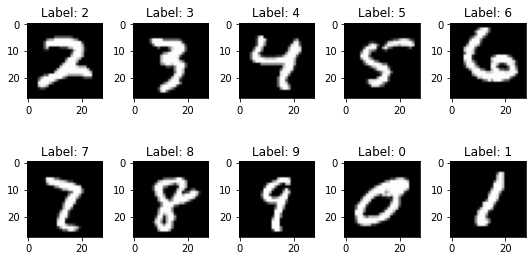

Test Accuracy of the unregularized model on the 10000 test images: 93.08999999999999 %


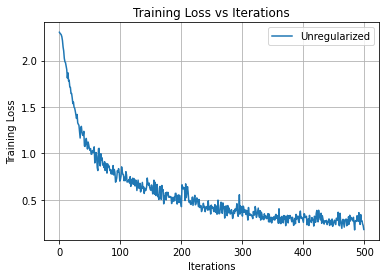

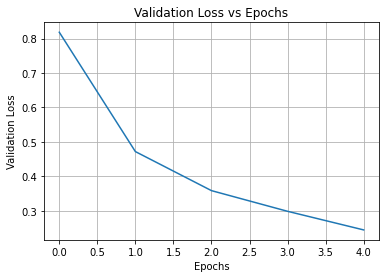

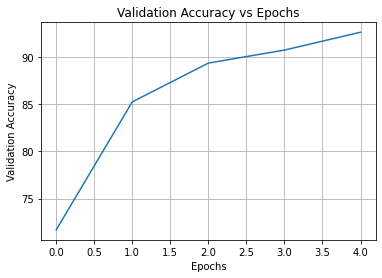

In [ ]:
Training_Testing(Vanilla_RNN(input_dim,hidden_dim,num_layers,output_dim),optimizer1,criterion1,regularizer= False)

Epoch 1 out of 5 epochs are over
Epoch 2 out of 5 epochs are over
Epoch 3 out of 5 epochs are over
Epoch 4 out of 5 epochs are over
Epoch 5 out of 5 epochs are over
Predicted tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])
real-Label tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])


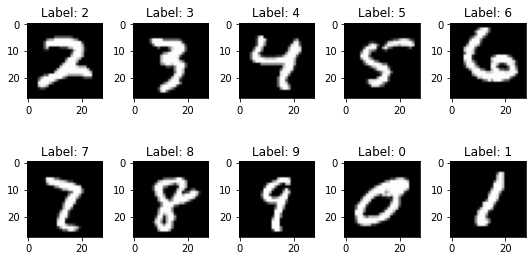

Test Accuracy of the L2 model on the 10000 test images: 91.9 %


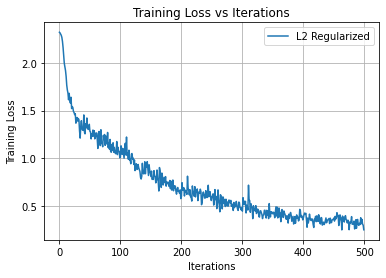

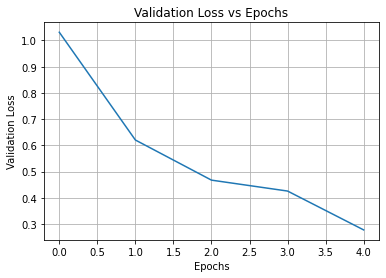

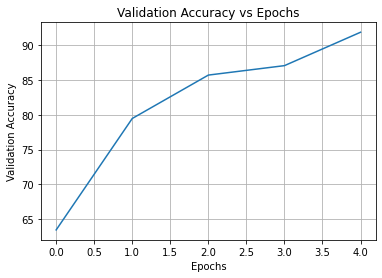

In [ ]:
Training_Testing(Vanilla_RNN(input_dim,hidden_dim,num_layers,output_dim),optimizer1,criterion1,regularizer= True)

In [ ]:
learning_rate = 0.002
epochs = 3
regul=0.005
criterion2 = nn.CrossEntropyLoss()

Epoch 1 out of 5 epochs are over
Epoch 2 out of 5 epochs are over
Epoch 3 out of 5 epochs are over
Epoch 4 out of 5 epochs are over
Epoch 5 out of 5 epochs are over
Predicted tensor([7, 4, 5, 6, 7, 8, 9, 0, 1])
real-Label tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])


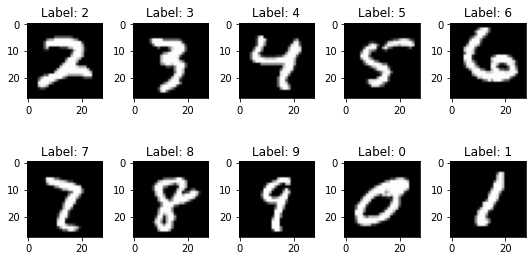

Test Accuracy of the unregularized model on the 10000 test images: 96.98 %


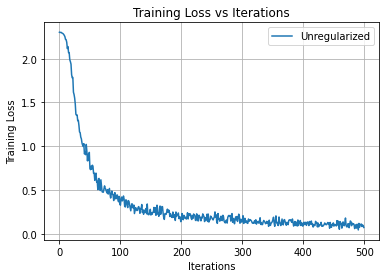

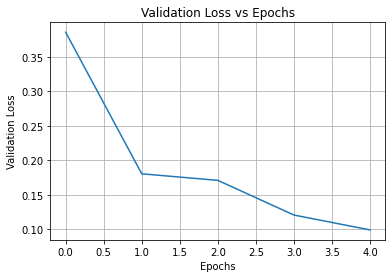

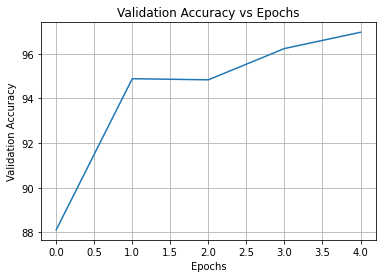

In [ ]:
Training_Testing(Vanilla_LSTM(input_dim,hidden_dim,num_layers,output_dim),optimizer1,criterion2,regularizer= False)

In [ ]:
optimizer1 = torch.optim.Adam(Vanilla_GRU(input_dim,hidden_dim,num_layers,output_dim).parameters(), lr=learning_rate)


Epoch 1 out of 5 epochs are over
Epoch 2 out of 5 epochs are over
Epoch 3 out of 5 epochs are over
Epoch 4 out of 5 epochs are over
Epoch 5 out of 5 epochs are over
Predicted tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])
real-Label tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])


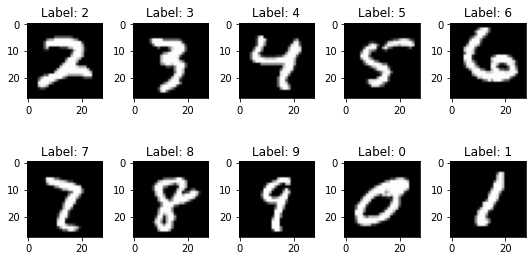

Test Accuracy of the unregularized model on the 10000 test images: 96.8 %


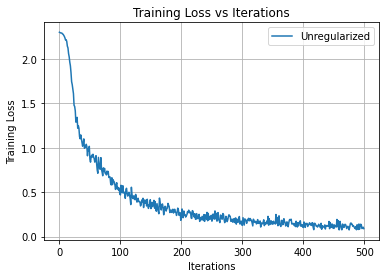

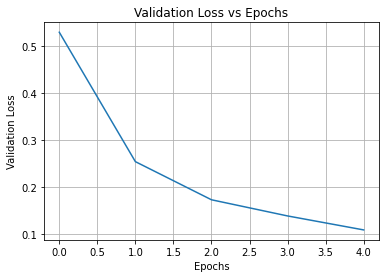

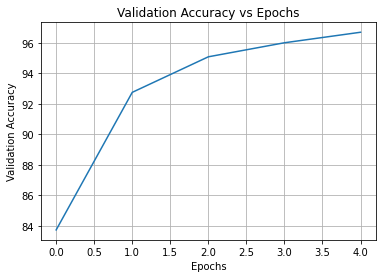

In [ ]:
Training_Testing(Vanilla_GRU(input_dim,hidden_dim,num_layers,output_dim),optimizer1,criterion2,regularizer= False)

Epoch 1 out of 5 epochs are over
Epoch 2 out of 5 epochs are over
Epoch 3 out of 5 epochs are over
Epoch 4 out of 5 epochs are over
Epoch 5 out of 5 epochs are over
Predicted tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])
real-Label tensor([3, 4, 5, 6, 7, 8, 9, 0, 1])


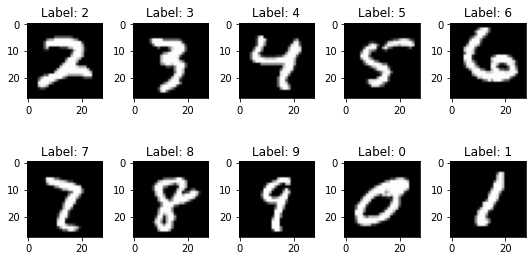

Test Accuracy of the unregularized model on the 10000 test images: 94.75 %


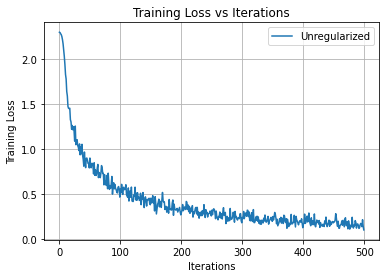

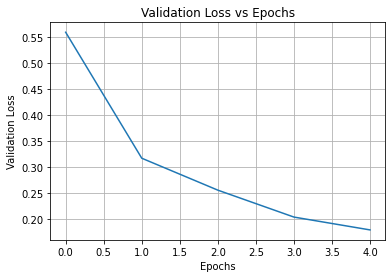

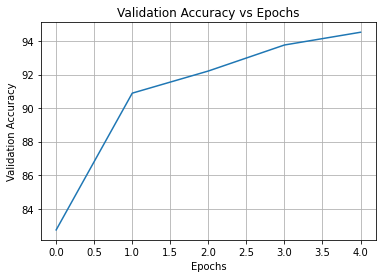

In [14]:
Training_Testing(Vanilla_BIRNN(),optimizer1,criterion1,regularizer= False)

2

In [15]:
epochs = 10

In [16]:
def Random_creator(L):
  #takes input of length L 
  return np.random.randint(0,10,L)

In [17]:
def one_hot_encoded(x):
  x_new = np.zeros((len(x),10))
  x_new[np.arange(len(x)), x] = 1
  return x_new

In [18]:
class LSTM_2(nn.Module):
  def __init__(self,hidden_size):
    super(LSTM_2,self).__init__()

    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(10,hidden_size)
    self.Hidden_layer = nn.Linear(hidden_size , 10)

  
  def forward(self,x):
    hiddenstate=torch.zeros(1,x.size(0),self.hidden_size)
    cellstate=torch.zeros(1,x.size(0),self.hidden_size)
    x=x.permute(1,0,2)
    out,(hs,cs) = self.lstm(x,(hiddenstate,cellstate)) 
    out = self.Hidden_layer(out[-1])
    return out.reshape(1,10)

In [19]:
trainranlist=[]
valranlist=[]
testranlist=[]
for i in range(100):
  for j in range(3,11):
    trainranlist.append(Random_creator(j))
  L=np.random.randint(3,11)
  valranlist.append(Random_creator(L))
  L=np.random.randint(3,11)
  testranlist.append(Random_creator(L))   
# testranlist

In [20]:
K=1
hidstatesize=[2,5,10]
traininglosslist2=[]
validationaccuracy_list2=[]
traininglosslist5=[]
validationaccuracy_list5=[]
traininglosslist10=[]
validationaccuracy_list10=[]

iteration=0
tempvalloss=0
correctval=0  

model41=LSTM_2(hidstatesize[0])
optimizer41 = torch.optim.Adam(model41.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(trainranlist)):  
    hotranlist=torch.zeros((1,len(trainranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoded(trainranlist[i]))
    
    output=model41(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([trainranlist[i][K]],dtype=torch.long)
    loss = criterion1(output, label.long())
    traininglosslist2.append(loss.item())
    
    optimizer41.zero_grad()
    loss.backward()
    optimizer41.step()
  
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(valranlist)):  
    hotranlist=torch.zeros((1,len(valranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoded(valranlist[i]))
    
    output=model41(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([valranlist[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  validationaccuracy_list2.append(correctval/len(valranlist)*100)


model42=LSTM_2(hidstatesize[1])
optimizer42 = torch.optim.Adam(model42.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(trainranlist)):  
    hotranlist=torch.zeros((1,len(trainranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoded(trainranlist[i]))
    
    output=model42(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([trainranlist[i][K]],dtype=torch.long)
    loss = criterion1(output, label.long())
    traininglosslist5.append(loss.item())
    
    optimizer42.zero_grad()
    loss.backward()
    optimizer42.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
  
  for i in range(len(valranlist)):  
    hotranlist=torch.zeros((1,len(valranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoded(valranlist[i]))
    
    output=model42(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([valranlist[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  validationaccuracy_list5.append(correctval/len(valranlist)*100)
  

model43=LSTM_2(hidstatesize[2])
optimizer43 = torch.optim.Adam(model43.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(trainranlist)):  
    hotranlist=torch.zeros((1,len(trainranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoded(trainranlist[i]))
    
    output=model43(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([trainranlist[i][K]],dtype=torch.long)
    loss = criterion1(output, label.long())
    traininglosslist10.append(loss.item())
    
    optimizer43.zero_grad()
    loss.backward()
    optimizer43.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 

  for i in range(len(valranlist)):  
    hotranlist=torch.zeros((1,len(valranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoded(valranlist[i]))
    
    output=model43(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([valranlist[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  validationaccuracy_list10.append(correctval/len(valranlist)*100)

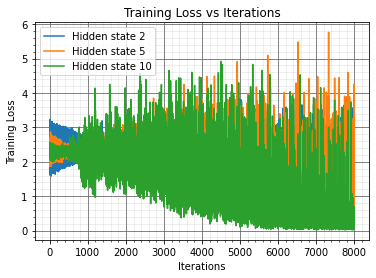

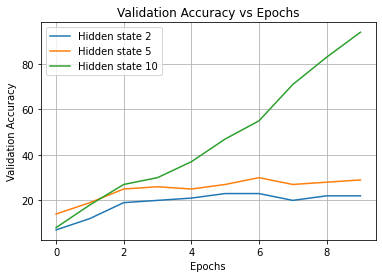

In [21]:
plt.figure(1)
xtrainloss=np.arange(len(traininglosslist2))
plt.plot(xtrainloss,traininglosslist2,label="Hidden state 2")
plt.plot(xtrainloss,traininglosslist5,label="Hidden state 5")
plt.plot(xtrainloss,traininglosslist10,label="Hidden state 10")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt.figure(2)
xvalloss=np.arange(len(validationaccuracy_list2))
plt.plot(xvalloss,validationaccuracy_list2,label="Hidden state 2")
plt.plot(xvalloss,validationaccuracy_list5,label="Hidden state 5")
plt.plot(xvalloss,validationaccuracy_list10,label="Hidden state 10")
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.show()


In [22]:
model41.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(testranlist)):
      hotranlist=torch.zeros((1,len(testranlist[i]),10))
      hotranlist[0]=torch.from_numpy(one_hot_encoded(testranlist[i]))
      output=model41(hotranlist.float())
      label=torch.tensor([testranlist[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 2 hidden states on the 100 test samples: {} %'.format((correct / len(testranlist)) * 100))
    
model42.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(testranlist)):
      hotranlist=torch.zeros((1,len(testranlist[i]),10))
      hotranlist[0]=torch.from_numpy(one_hot_encoded(testranlist[i]))
      output=model42(hotranlist.float())
      label=torch.tensor([testranlist[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 5 hidden states on the 100 test samples: {} %'.format((correct / len(testranlist)) * 100))
    
model43.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(testranlist)):
      hotranlist=torch.zeros((1,len(testranlist[i]),10))
      hotranlist[0]=torch.from_numpy(one_hot_encoded(testranlist[i]))
      output=model43(hotranlist.float())
      label=torch.tensor([testranlist[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 10 hidden states on the 100 test samples: {} %'.format((correct / len(testranlist)) * 100))


Test Accuracy of the model with 2 hidden states on the 100 test samples: 16.0 %
Test Accuracy of the model with 5 hidden states on the 100 test samples: 30.0 %
Test Accuracy of the model with 10 hidden states on the 100 test samples: 96.0 %


In [24]:


for i in range(3,11):
  print("For Length",i)
  for j in range(3):
      a=Random_creator(i)
      hotranlist=torch.zeros((1,len(a),10))
      hotranlist[0]=torch.from_numpy(one_hot_encoded(a))
      output=model43(hotranlist.float())
      label=torch.tensor([a[K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      print("Array:",a,"Prediction at position 2:",predicted.item())



For Length 3
Array: [5 5 6] Prediction at position 2: 5
Array: [5 7 2] Prediction at position 2: 7
Array: [8 2 0] Prediction at position 2: 2
For Length 4
Array: [3 3 2 5] Prediction at position 2: 3
Array: [6 2 3 5] Prediction at position 2: 2
Array: [5 0 2 6] Prediction at position 2: 0
For Length 5
Array: [2 6 6 3 2] Prediction at position 2: 6
Array: [2 9 4 5 7] Prediction at position 2: 9
Array: [7 2 1 4 4] Prediction at position 2: 2
For Length 6
Array: [4 6 8 3 9 3] Prediction at position 2: 3
Array: [2 9 9 7 2 7] Prediction at position 2: 9
Array: [9 6 5 1 3 9] Prediction at position 2: 6
For Length 7
Array: [0 3 0 2 1 5 6] Prediction at position 2: 3
Array: [9 5 4 5 2 5 0] Prediction at position 2: 5
Array: [8 4 6 7 0 0 1] Prediction at position 2: 4
For Length 8
Array: [1 9 8 0 9 5 9 6] Prediction at position 2: 9
Array: [3 2 5 4 9 2 0 1] Prediction at position 2: 2
Array: [0 0 4 8 7 9 7 6] Prediction at position 2: 0
For Length 9
Array: [7 8 0 6 7 9 5 2 4] Prediction at posi

In [25]:
def binsgenerator(L):
  N1=np.random.randint(0,2**(L-1))
  N2=np.random.randint(0,2**(L-1))
  S=N1+N2
  binlen=L
  B1=np.zeros((1,binlen))
  B2=np.zeros((1,binlen))
  B3=np.zeros((binlen))
  b=np.flip(np.array(list(np.binary_repr(N1)), dtype=int))
  B1[0][0:len(b)]=b[0:]
  b=np.flip(np.array(list(np.binary_repr(N2)), dtype=int))
  B2[0][0:len(b)]=b[0:]
  b=np.flip(np.array(list(np.binary_repr(S)), dtype=int))
  B3[0:len(b)]=b[0:]
  return(np.concatenate((np.transpose(B1),np.transpose(B2)),axis=1),B3)  


In [26]:
traininput=[]
trainoutput=[]
for i in range(250):
  L=np.random.randint(1,21)
  a,b=binsgenerator(L)
  traininput.append(a)
  trainoutput.append(b)
  
testinput=[]
testoutput=[]
for i in range(100):
  L=np.random.randint(1,21)
  a,b=binsgenerator(L)
  testinput.append(a)
  testoutput.append(b)
  
fintestinput=[]
fintestoutput=[]
for j in range(1,21):
  for i in range(100):
    a,b=binsgenerator(j)
    fintestinput.append(a)
    fintestoutput.append(b)


In [27]:
class LSTMQ3(nn.Module):
  def __init__(self,hidsize):
    super(LSTMQ3, self).__init__()
    self.hidsize=hidsize
    self.lstm = nn.LSTM(2,hidsize)
    self.layer2 = nn.Sequential(
        nn.Linear(hidsize,1),
        nn.Sigmoid())
    
  def forward(self, X):
    X=X.permute(1,0,2)
    hiddenstate=torch.zeros(1,X.size(1),self.hidsize)
    cellstate=torch.zeros(1,X.size(1),self.hidsize)
    out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate))
    out = self.layer2(out)
    return out.reshape(X.size(0))


In [39]:
learning_rate = 0.01
epochs = 10
criterion5 = nn.MSELoss()
model51=LSTMQ3(3)
optimizer51 = torch.optim.Adam(model51.parameters(), lr=learning_rate)
model52=LSTMQ3(10)
optimizer52 = torch.optim.Adam(model52.parameters(), lr=learning_rate)



In [40]:
traininglosslist=[]
testlosslist=[]
correcttestlist=[]
for epoch in range(epochs):
  for i in range(int(len(traininput))):
    a=torch.zeros((1,traininput[i].shape[0],traininput[i].shape[1]))
    a[0]=torch.from_numpy(traininput[i])
    output=model51(a.float())
    label=torch.tensor(np.transpose(trainoutput[i]))
    loss = criterion5(output,label.float())
    traininglosslist.append(loss.item())
      
    optimizer51.zero_grad()
    loss.backward()
    optimizer51.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(testinput)):
    correct=0
    a=torch.zeros((1,testinput[i].shape[0],testinput[i].shape[1]))
    a[0]=torch.from_numpy(testinput[i])
    output=model51(a.float())
    label=torch.tensor(np.transpose(testoutput[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  correcttestlist.append(100*correct/iteration)
  testlosslist.append(tempvalloss/iteration)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

Epoch 1 out of 10 epochs are over
Epoch 2 out of 10 epochs are over
Epoch 3 out of 10 epochs are over
Epoch 4 out of 10 epochs are over
Epoch 5 out of 10 epochs are over
Epoch 6 out of 10 epochs are over
Epoch 7 out of 10 epochs are over
Epoch 8 out of 10 epochs are over
Epoch 9 out of 10 epochs are over
Epoch 10 out of 10 epochs are over


In [41]:
traininglosslist2=[]
testlosslist2=[]
correcttestlist2=[]
for epoch in range(epochs):
  for i in range(len(traininput)):
    a=torch.zeros((1,traininput[i].shape[0],traininput[i].shape[1]))
    a[0]=torch.from_numpy(traininput[i])
    output=model52(a.float())
    label=torch.tensor(np.transpose(trainoutput[i]))
    loss = criterion5(output,label.float())
    traininglosslist2.append(loss.item())
      
    optimizer52.zero_grad()
    loss.backward()
    optimizer52.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(testinput)):
    correct=0
    a=torch.zeros((1,testinput[i].shape[0],testinput[i].shape[1]))
    a[0]=torch.from_numpy(testinput[i])
    output=model52(a.float())
    label=torch.tensor(np.transpose(testoutput[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  correcttestlist2.append(100*correct/iteration)
  testlosslist2.append(tempvalloss/iteration)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')


Epoch 1 out of 10 epochs are over
Epoch 2 out of 10 epochs are over
Epoch 3 out of 10 epochs are over
Epoch 4 out of 10 epochs are over
Epoch 5 out of 10 epochs are over
Epoch 6 out of 10 epochs are over
Epoch 7 out of 10 epochs are over
Epoch 8 out of 10 epochs are over
Epoch 9 out of 10 epochs are over
Epoch 10 out of 10 epochs are over


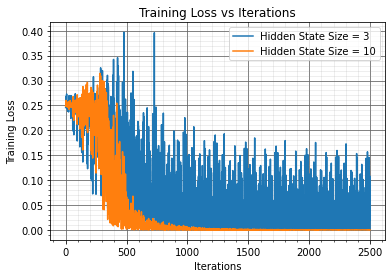

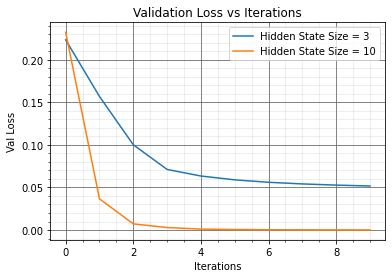

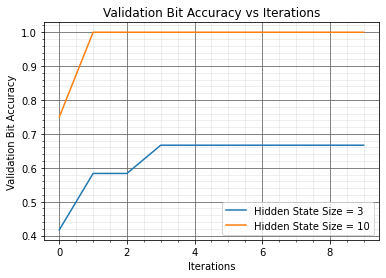

In [42]:
plt.figure(1)
xtrainloss=np.arange(len(traininglosslist))
plt.plot(xtrainloss,traininglosslist,label="Hidden State Size = 3")
plt.plot(xtrainloss,traininglosslist2,label="Hidden State Size = 10")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt.figure(2)
xtestloss=np.arange(len(testlosslist))
plt.plot(xtestloss,testlosslist,label="Hidden State Size = 3")
plt.plot(xtestloss,testlosslist2,label="Hidden State Size = 10")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Val Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()

plt.figure(3)
xbittrain=np.arange(len(correcttestlist))
plt.plot(xbittrain,correcttestlist,label="Hidden State Size = 3")
plt.plot(xbittrain,correcttestlist2,label="Hidden State Size = 10")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Bit Accuracy')
plt.title('Validation Bit Accuracy vs Iterations')
plt.legend()


plt.show()


In [43]:
model51.eval()
correctarr1 = np.zeros(20)
correctarr2 = np.zeros(20)
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model51(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


    print('Bit accuracy when hidden states = 3:',(np.sum(correctarr1)/20))

model52.eval()    
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model52(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr2[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Bit accuracy when hidden states = 10:',(np.sum(correctarr2)/20))


Bit accuracy when hidden states = 3: 92.59437075394503
Bit accuracy when hidden states = 10: 100.0


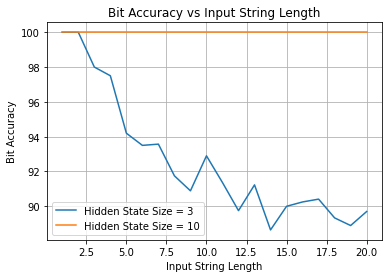

In [44]:
x=np.arange(1,21)
plt.figure(1)
plt.plot(x,correctarr1,label="Hidden State Size = 3")
plt.plot(x,correctarr2,label="Hidden State Size = 10")
plt.xlabel('Input String Length')
plt.ylabel('Bit Accuracy')
plt.title('Bit Accuracy vs Input String Length')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
learning_rate = 0.01
epochs = 5
criterion5 = nn.MSELoss()
model53=LSTMQ3(5)
optimizer53 = torch.optim.Adam(model53.parameters(), lr=learning_rate)
model54=LSTMQ3(5)
optimizer54 = torch.optim.Adam(model54.parameters(), lr=learning_rate)

In [46]:
traininglosslist=[]
testlosslist=[]
correcttestlist=[]
for epoch in range(epochs):
  for i in range(int(len(traininput))):
    a=torch.zeros((1,traininput[i].shape[0],traininput[i].shape[1]))
    a[0]=torch.from_numpy(traininput[i])
    output=model53(a.float())
    label=torch.tensor(np.transpose(trainoutput[i]))
    loss = criterion5(output,label.float())
    traininglosslist.append(loss.item())
      
    optimizer53.zero_grad()
    loss.backward()
    optimizer53.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(testinput)):
    correct=0
    a=torch.zeros((1,testinput[i].shape[0],testinput[i].shape[1]))
    a[0]=torch.from_numpy(testinput[i])
    output=model53(a.float())
    label=torch.tensor(np.transpose(testoutput[i]))
    loss = criterion5(output,label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  correcttestlist.append(100*correct/iteration)
  testlosslist.append(tempvalloss/iteration)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')


Epoch 1 out of 5 epochs are over
Epoch 2 out of 5 epochs are over
Epoch 3 out of 5 epochs are over
Epoch 4 out of 5 epochs are over
Epoch 5 out of 5 epochs are over


In [47]:
traininglosslist2=[]
testlosslist2=[]
correcttestlist2=[]
for epoch in range(epochs):
  for i in range(int(len(traininput))):
    a=torch.zeros((1,traininput[i].shape[0],traininput[i].shape[1]))
    a[0]=torch.from_numpy(traininput[i])
    output=model54(a.float())
    label=torch.tensor(np.transpose(trainoutput[i]))
    loss = torch.sum(-1*torch.log(output.clamp(1e-10))*label.float())
    traininglosslist2.append(loss.item())
      
    optimizer54.zero_grad()
    loss.backward()
    optimizer54.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(testinput)):
    correct=0
    a=torch.zeros((1,testinput[i].shape[0],testinput[i].shape[1]))
    a[0]=torch.from_numpy(testinput[i])
    output=model54(a.float())
    label=torch.tensor(np.transpose(testoutput[i]))
    loss = torch.sum(-1*torch.log(output.clamp(1e-10))*label.float())
    iteration+=1
    tempvalloss+=loss.item()
    
    predicted=torch.zeros(output.shape)
    predicted[output>=0.5]=1
    predicted[output<0.5]=0
    correct += (predicted == label.float()).sum().item()/len(label)
    
  correcttestlist2.append(100*correct/iteration)
  testlosslist2.append(tempvalloss/iteration)
  print('Epoch',epoch+1,'out of',epochs,'epochs are over')

Epoch 1 out of 5 epochs are over
Epoch 2 out of 5 epochs are over
Epoch 3 out of 5 epochs are over
Epoch 4 out of 5 epochs are over
Epoch 5 out of 5 epochs are over


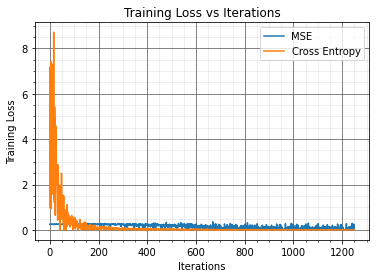

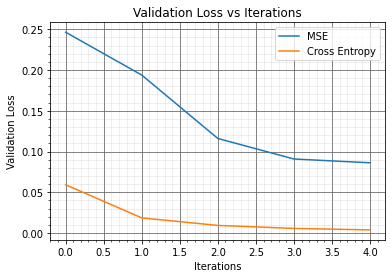

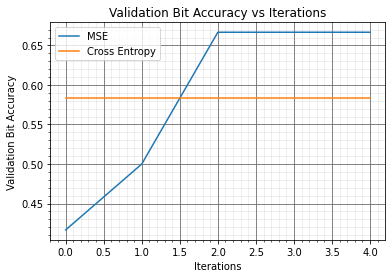

In [48]:
plt.figure(1)
xtrainloss=np.arange(len(traininglosslist))
plt.plot(xtrainloss,traininglosslist,label="MSE")
plt.plot(xtrainloss,traininglosslist2,label="Cross Entropy")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt.figure(2)
xtestloss=np.arange(len(testlosslist))
plt.plot(xtestloss,testlosslist,label="MSE")
plt.plot(xtestloss,testlosslist2,label="Cross Entropy")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()

plt.figure(3)
xbittrain=np.arange(len(correcttestlist))
plt.plot(xbittrain,correcttestlist,label="MSE")
plt.plot(xbittrain,correcttestlist2,label="Cross Entropy")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Bit Accuracy')
plt.title('Validation Bit Accuracy vs Iterations')
plt.legend()


plt.show()
